# Proyek Analisis Data:

# **PreProcessing**

## Import Semua Packages/Library yang Digunakan

In [12]:
!pip install -U imbalanced-learn


Install library yang tidak terdapat di google colab

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import semua library yang diperlukan

## Data Wrangling

### Gathering Data

In [14]:
df = pd.read_csv('/content/drive/MyDrive/DBS/TUGAS ANALISIS DATA/Air-quality-dataset/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv', index_col='No')
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
No,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


Membaca data dengan pandas

In [15]:
df.columns

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

Melihat kolom apa saja yang terdapat di data

In [16]:
df.shape

(35064, 17)

Melihat ukuran data

**Insight:**
- Terdapat 18 kolom dengan 17 kolom fitur dan 1 kolom index dan 35.064 baris pada data kualitas udara

### Assessing Data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 1 to 35064
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     35064 non-null  int64  
 1   month    35064 non-null  int64  
 2   day      35064 non-null  int64  
 3   hour     35064 non-null  int64  
 4   PM2.5    34139 non-null  float64
 5   PM10     34346 non-null  float64
 6   SO2      34129 non-null  float64
 7   NO2      34041 non-null  float64
 8   CO       33288 non-null  float64
 9   O3       33345 non-null  float64
 10  TEMP     35044 non-null  float64
 11  PRES     35044 non-null  float64
 12  DEWP     35044 non-null  float64
 13  RAIN     35044 non-null  float64
 14  wd       34983 non-null  object 
 15  WSPM     35050 non-null  float64
 16  station  35064 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 4.8+ MB


Melihat tipe data pada tiap kolom

In [18]:
df.isna().sum()

,0
year,0
month,0
day,0
hour,0
PM2.5,925
PM10,718
SO2,935
NO2,1023
CO,1776
O3,1719


Melihat kolom-kolom yang memiliki nilai kosong

In [19]:
df.duplicated().sum()

np.int64(0)

Melihat apakah terdapat nilai duplikat

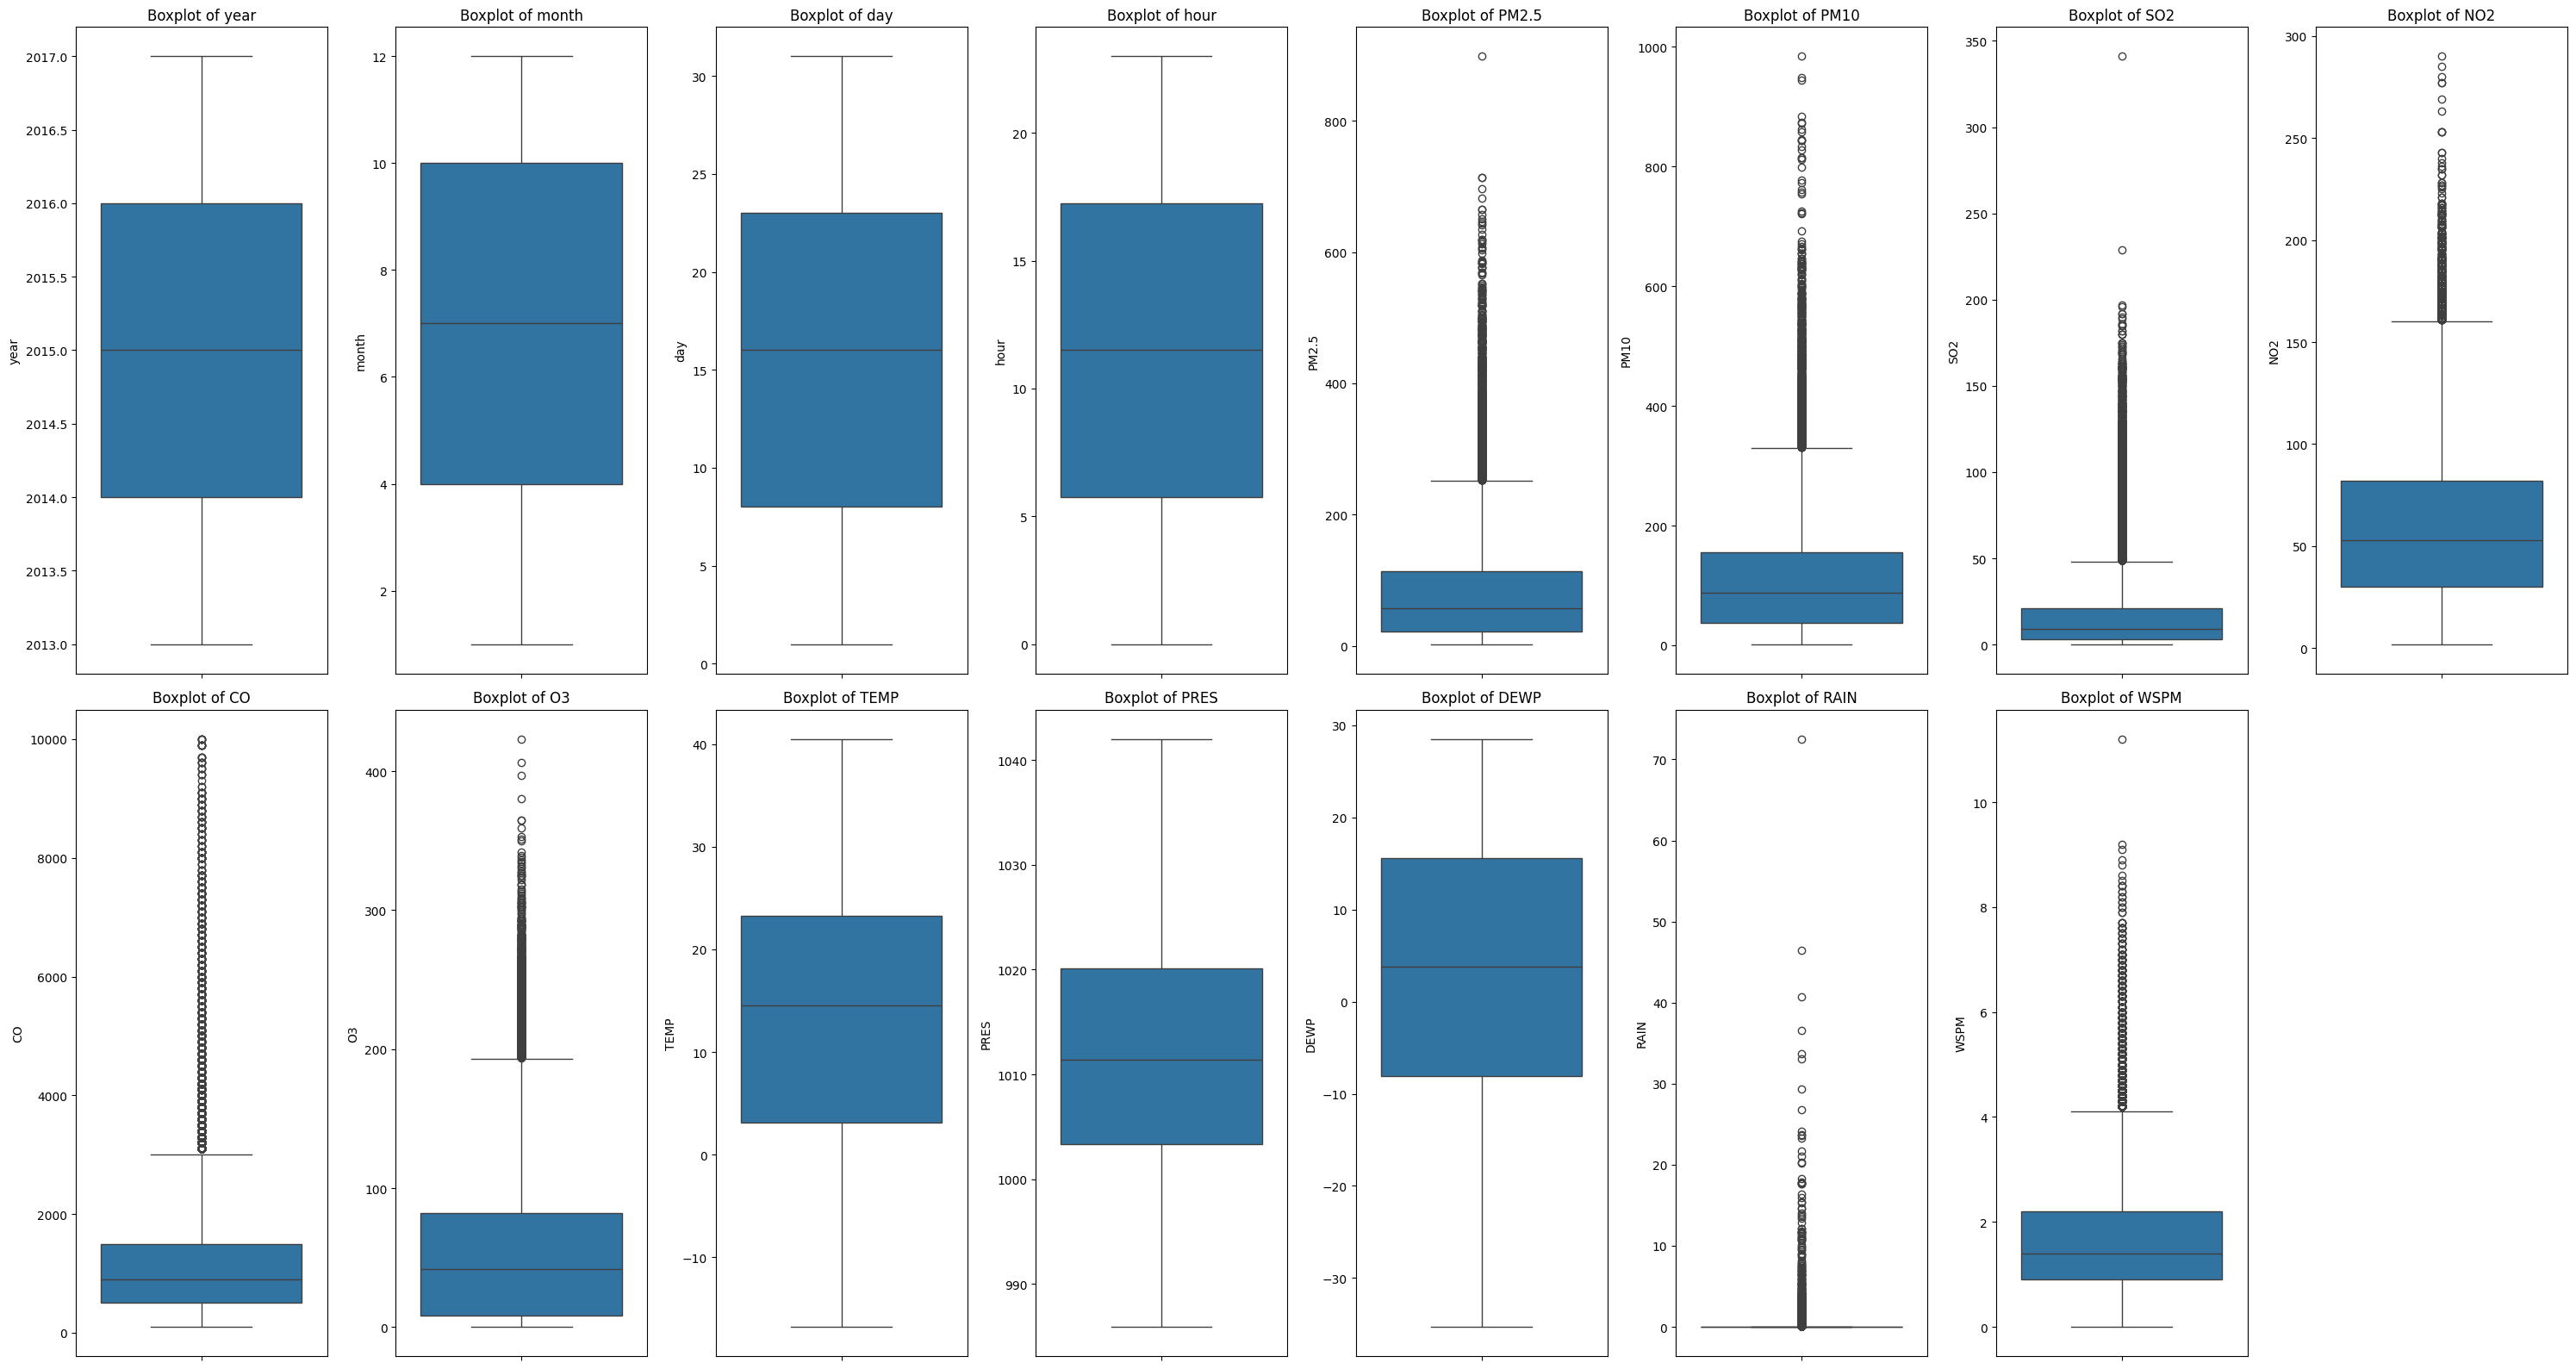

In [20]:
# Mengatur ukuran figure
plt.figure(figsize=(30, 16))

# Loop melalui setiap kolom dalam dataset
df_select_numeric = df.select_dtypes(include=['number']) # Hanya kolom numerik
for i, col in enumerate(df_select_numeric.columns, 1):
    plt.subplot(2, (len(df_select_numeric.columns) + 1) // 2, i)
    sns.boxplot(y=df_select_numeric[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')

plt.tight_layout()

Melihat sebaran boxplot dan apakah terdapat outlier di tiap kolom

**Insight:**
- Terdapat banyak sekali data kosong/missing value pada kolom-kolom tersebut
- Tidak terdapat duplikasi data
- Banyak sekali outlier pada data-data numerik

### Explore Data Analysis

In [21]:
df_numeric = df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']]
df_numeric.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,34139.000000,34346.000000,34129.000000,34041.000000,33288.000000,33345.000000,35044.000000,35044.000000,35044.000000,35044.000000,35050.000000
mean,82.773611,110.060391,17.375901,59.305833,1262.945145,56.353358,13.584607,1011.846920,3.123062,0.067421,1.708496
std,82.135694,95.223005,22.823017,37.116200,1221.436236,57.916327,11.399097,10.404047,13.688896,0.910056,1.204071
min,3.000000,2.000000,0.285600,2.000000,100.000000,0.214200,-16.800000,985.900000,-35.300000,0.000000,0.000000
25%,22.000000,38.000000,3.000000,30.000000,500.000000,8.000000,3.100000,1003.300000,-8.100000,0.000000,0.900000
50%,58.000000,87.000000,9.000000,53.000000,900.000000,42.000000,14.500000,1011.400000,3.800000,0.000000,1.400000
75%,114.000000,155.000000,21.000000,82.000000,1500.000000,82.000000,23.300000,1020.100000,15.600000,0.000000,2.200000
max,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000,40.500000,1042.000000,28.500000,72.500000,11.200000


Melakukan eksplorasi data numerik

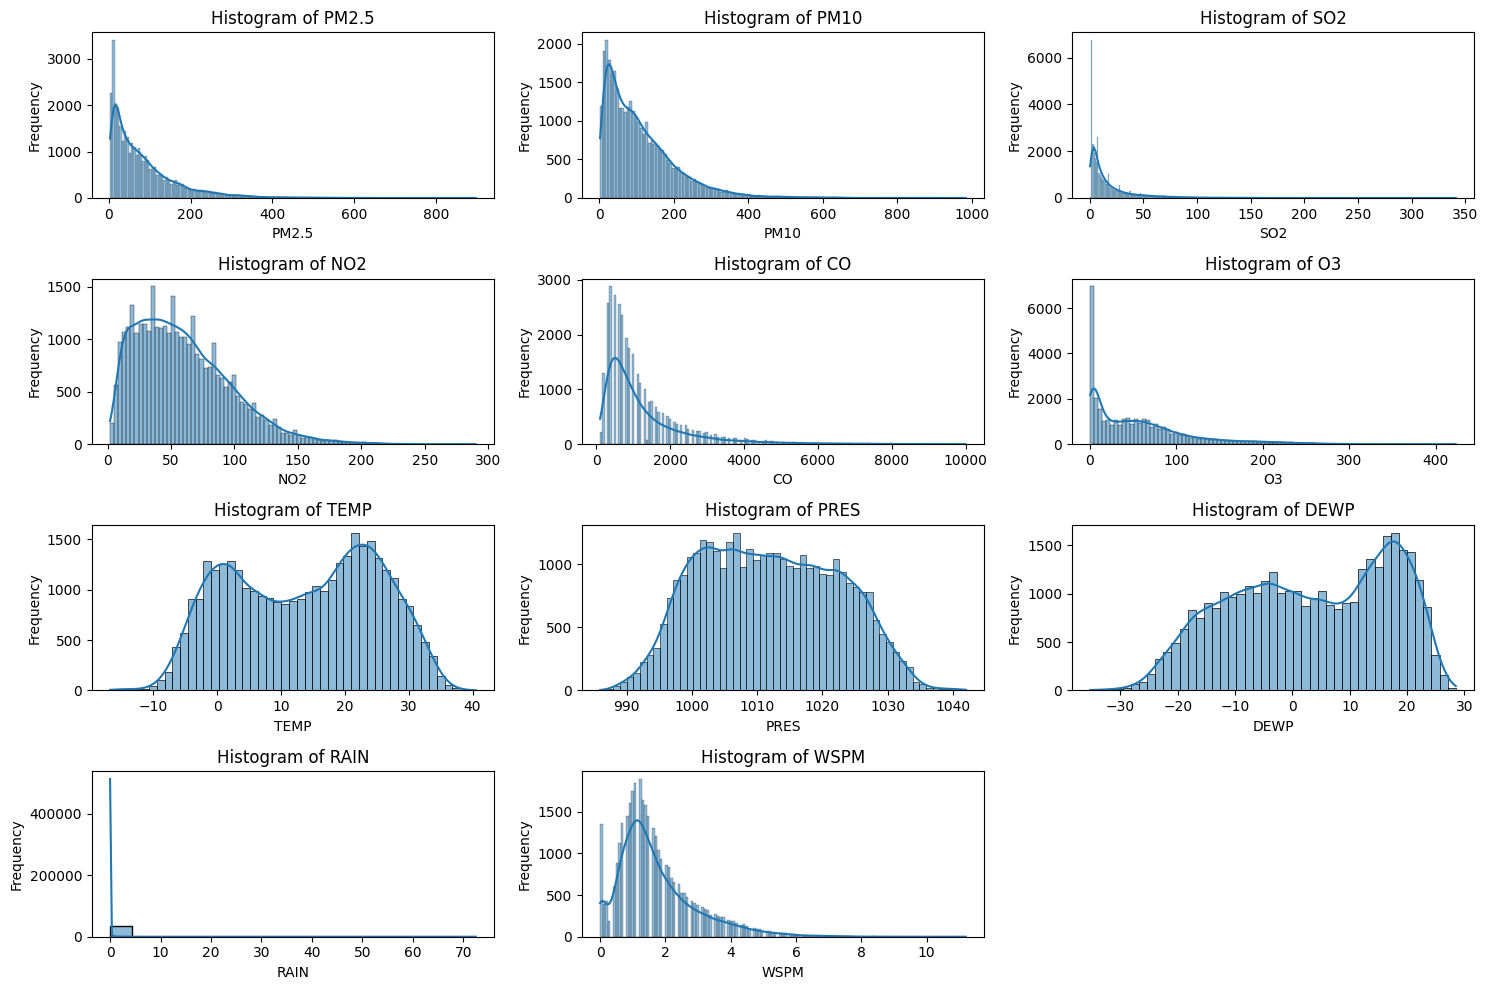

In [22]:
# Set the figure size
plt.figure(figsize=(15, 10))

# Iterate through each numeric column and create a histogram
for i, col in enumerate(df_numeric.columns):
    plt.subplot(4, 3, i + 1)  # Adjust subplot layout as needed
    sns.histplot(df_numeric[col], kde=True)  # Added kde for density estimation
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Melihat kembali sebaran data numerik

- Bagaimana curah hujan tiap bulannya dalam kurun waktu satu tahun

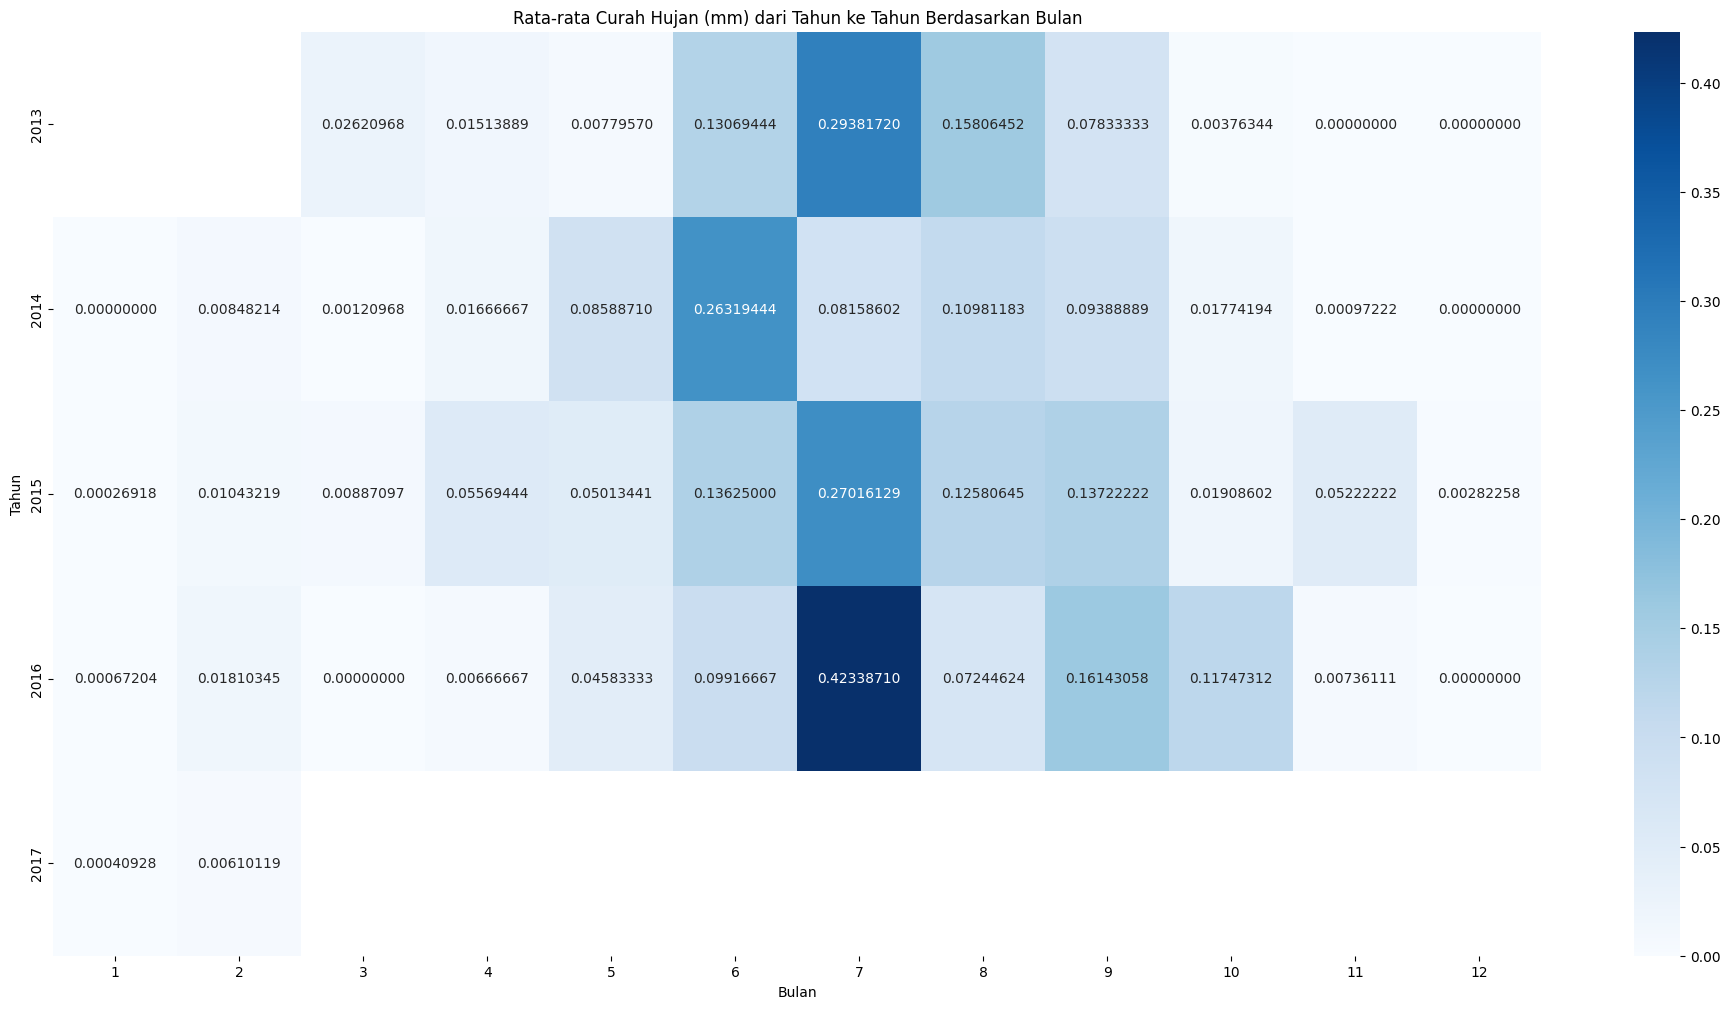

In [23]:
rain_avg = df.groupby(['year', 'month'])['RAIN'].mean().reset_index()

# Buat pivot table untuk heatmap
rain_pivot = rain_avg.pivot(index='year', columns='month', values='RAIN')

# Plot menggunakan heatmap
plt.figure(figsize=(24, 12))
sns.heatmap(rain_pivot, cmap="Blues", annot=True, fmt=".8f")
plt.title("Rata-rata Curah Hujan (mm) dari Tahun ke Tahun Berdasarkan Bulan")
plt.xlabel("Bulan")
plt.ylabel("Tahun")
plt.show()

Membuat heatmap untuk melihat bagaimana sebaran jumlah hujan, dengan sumbu x adalah bulan dan sumbu y adalah tahun. Dapat dilihat hampir tiap bulan ke-7 menjadi puncak hujan

Analisis pertanyaan kedua
- Faktor apa yang menyebabkan curah hujan

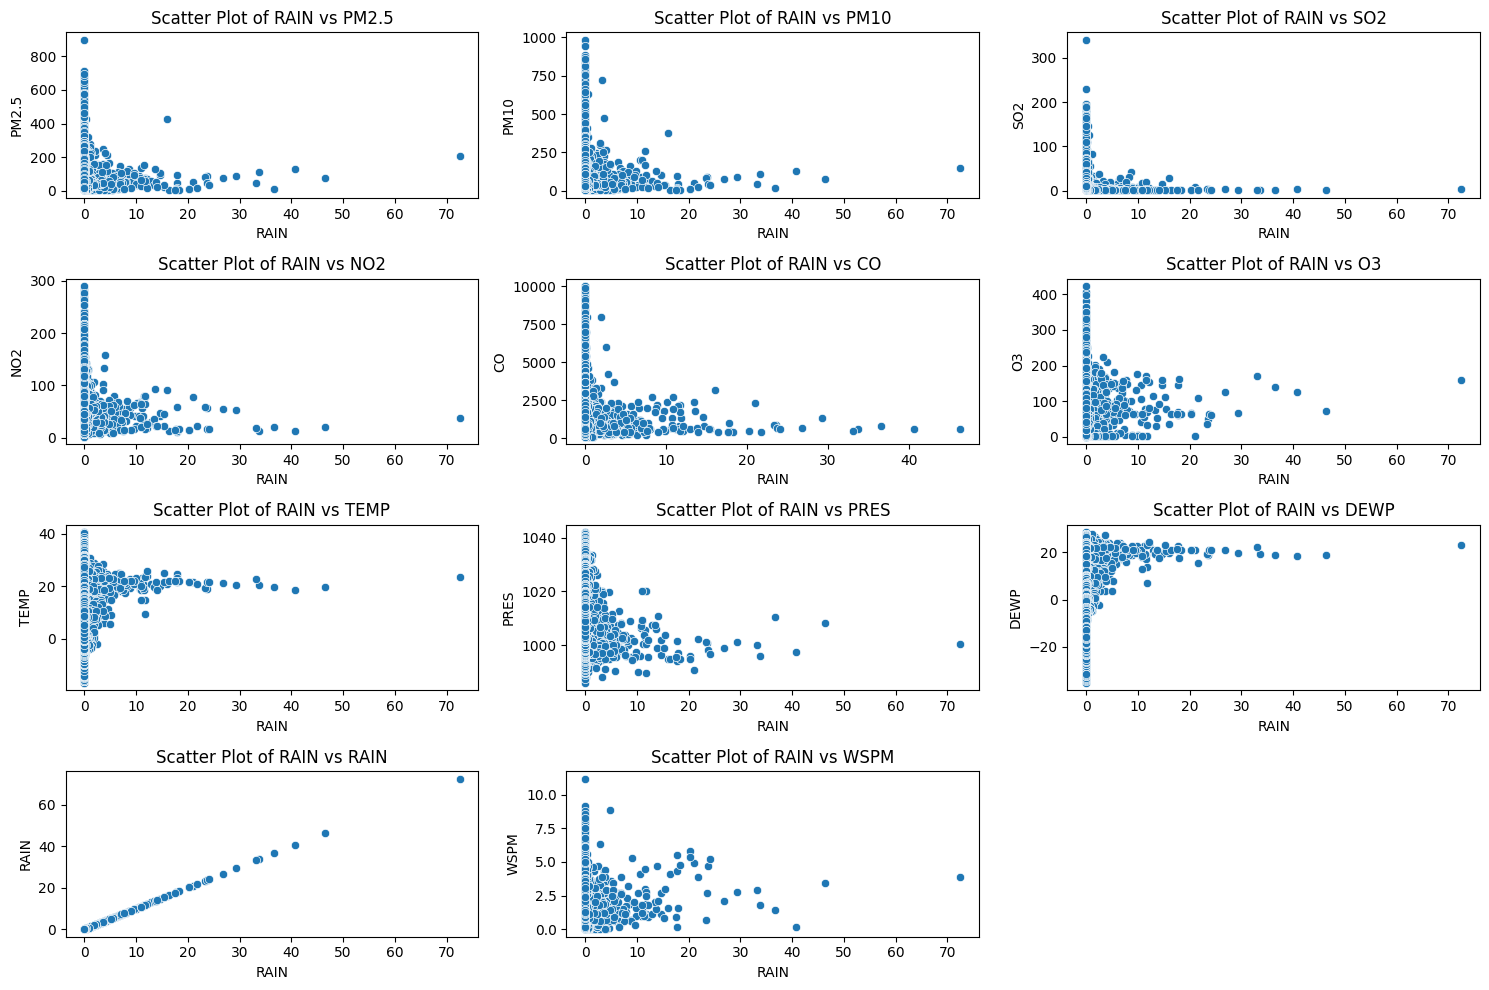

In [24]:
# Set the figure size
plt.figure(figsize=(15, 10))

# Iterate through each numeric column and create a histogram
for i, col in enumerate(df_numeric.columns):
    plt.subplot(4, 3, i + 1)  # Adjust subplot layout as needed
    sns.scatterplot(x=df['RAIN'], y=df_numeric[col])  # Added kde for density estimation
    plt.title(f'Scatter Plot of RAIN vs {col}')
    plt.xlabel('RAIN')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [25]:
df_numeric.corr()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.879104,0.481025,0.684986,0.785006,-0.161448,-0.129415,-0.005727,0.120112,-0.014004,-0.278740
PM10,0.879104,1.000000,0.469045,0.652325,0.680404,-0.139914,-0.111147,-0.035594,0.061667,-0.027795,-0.183132
SO2,0.481025,0.469045,1.000000,0.432081,0.540275,-0.200193,-0.350608,0.203921,-0.282565,-0.041609,-0.113115
NO2,0.684986,0.652325,0.432081,1.000000,0.690202,-0.500380,-0.241059,0.081636,0.067344,-0.040077,-0.491570
CO,0.785006,0.680404,0.540275,0.690202,1.000000,-0.326462,-0.366898,0.215556,-0.098120,-0.018429,-0.284888
O3,-0.161448,-0.139914,-0.200193,-0.500380,-0.326462,1.000000,0.589063,-0.424294,0.294944,0.025099,0.341100
TEMP,-0.129415,-0.111147,-0.350608,-0.241059,-0.366898,0.589063,1.000000,-0.827133,0.823099,0.036601,0.037913
PRES,-0.005727,-0.035594,0.203921,0.081636,0.215556,-0.424294,-0.827133,1.000000,-0.776384,-0.060403,0.071322
DEWP,0.120112,0.061667,-0.282565,0.067344,-0.098120,0.294944,0.823099,-0.776384,1.000000,0.080789,-0.305063
RAIN,-0.014004,-0.027795,-0.041609,-0.040077,-0.018429,0.025099,0.036601,-0.060403,0.080789,1.000000,0.022475


Melihat apakah terdapat korelasi fitur antara hujan dengan fitur yang lainnya. Tidak terdapat korelasi pada fitur RAIN dengan fitur yang lain

**Insight:**
- Melakukan pivot tabel untuk melihat rata-rata curah hujan tiap bulannya dalam kurun waktu 2013/2017
- Melihat korelasi antara hujan dengan atribut yang lain

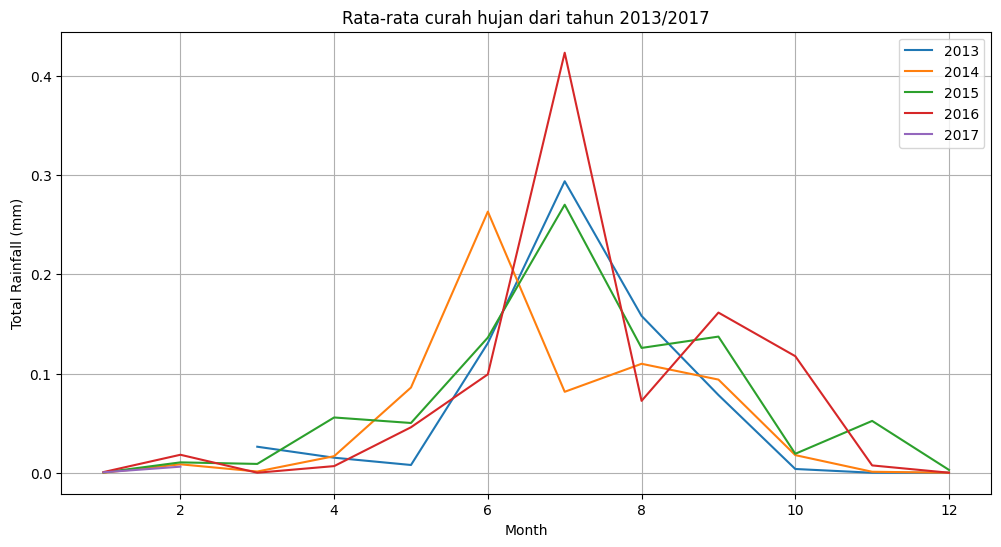

In [26]:
# Group data by year and month, then sum the rainfall
rain_sum = df.groupby(['year', 'month'])['RAIN'].mean().reset_index()

# Create the line chart
plt.figure(figsize=(12, 6))
for year in rain_sum['year'].unique():
    year_data = rain_sum[rain_sum['year'] == year]
    plt.plot(year_data['month'], year_data['RAIN'], label=str(year))

plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.title("Rata-rata curah hujan dari tahun 2013/2017")
plt.legend()
plt.grid(True)
plt.show()

Membuat grafik sebaran hujan, untuk memudahkan pemahaman sebaran hujan. Dan dapat dilihat hampir tiap bulan ke-7 menjadi puncak jumlah hujan

### Cleaning Data

In [27]:
df = df.drop(columns = ['station'])

Membuang kolom station, karena hanya 1 stasiun yang dianalisis

In [28]:
# Mengisi missing value kolom numerik dengan rata-rata
for col in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']:
    df[col] = df[col].fillna(value=df[col].mean())

# Mengisi missing value kolom kategorik dengan modus
df['wd'] = df['wd'].fillna(df['wd'].mode()[0])

#Melihat kembali data apakah masih ada missing value
print(df.isna().sum())

year     0
month    0
day      0
hour     0
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64


Melakukan pembersihan data kosong dengan imputation, kolom numerik diisi dengan rata-rata dan kolom kategorik diisi dengan modus

In [29]:
# Imputasi outlier dengan IQR
def impute_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

df_no_outlier = df.copy()
# Lakukan hal yang sama untuk kolom lain yang mengandung outlier
for col in ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM2.5', 'RAIN']:
    df_no_outlier = impute_outliers_iqr(df_no_outlier, col)


Melakukan imputation pada outlier, mengganti nilai outlier dengan batas atas/bawah

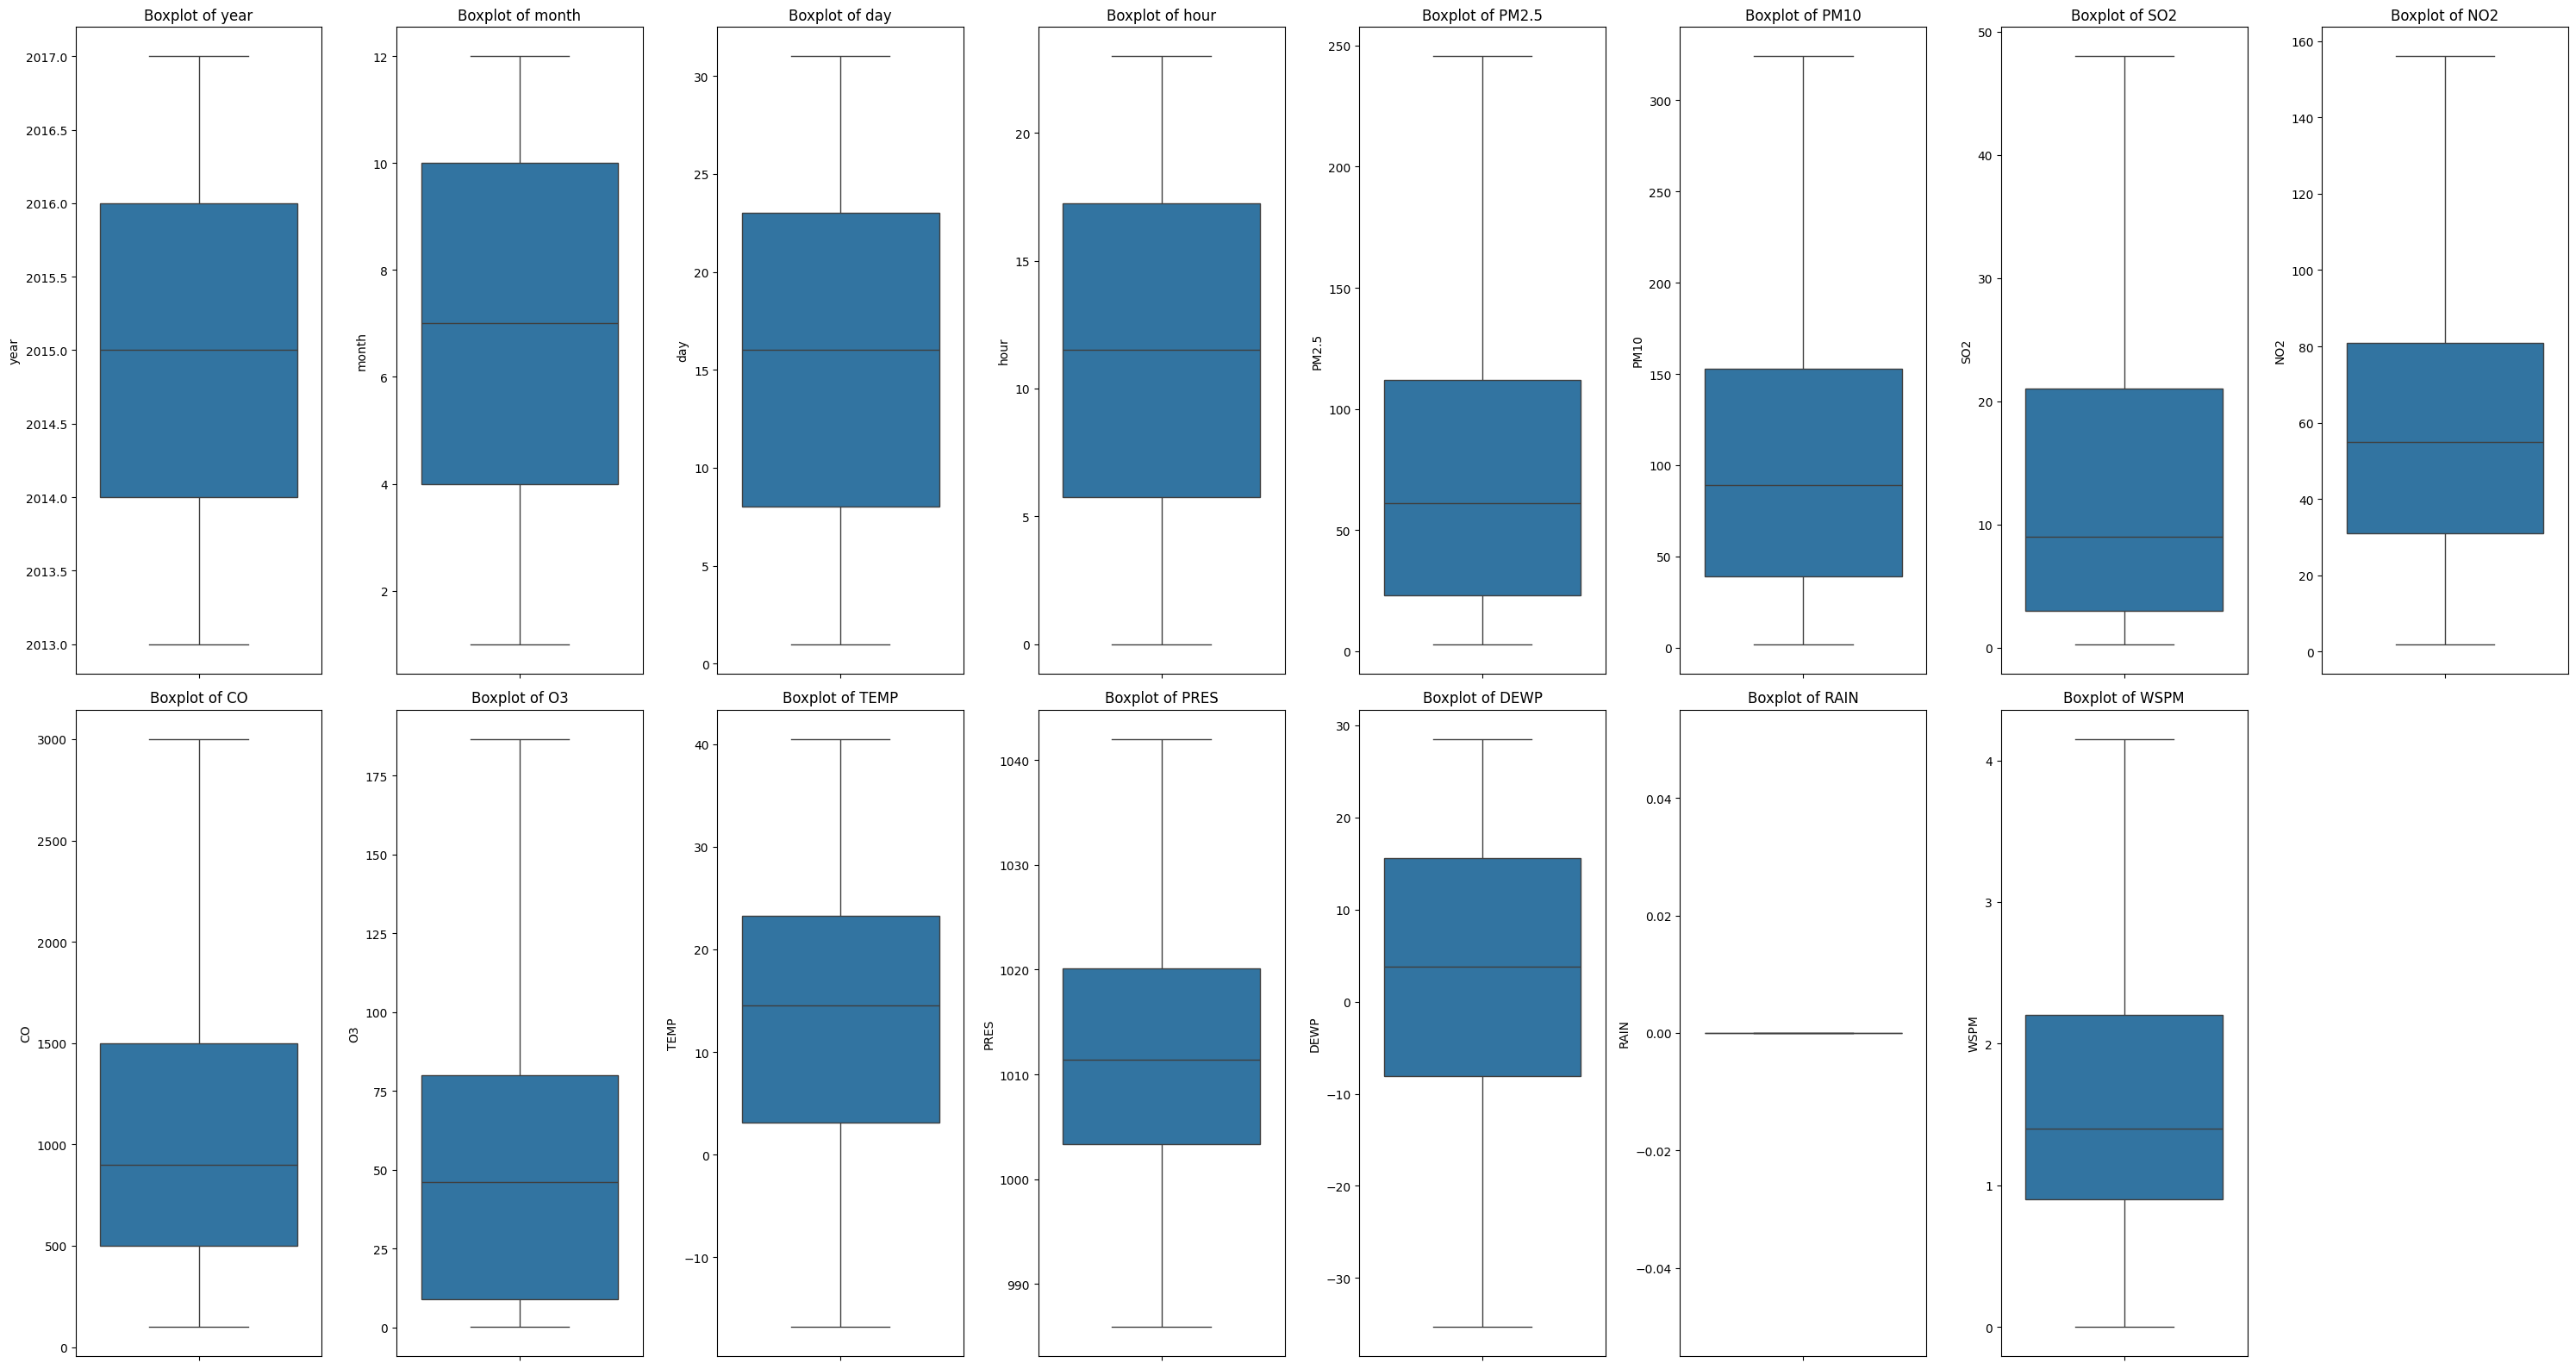

In [30]:
# Mengatur ukuran figure
plt.figure(figsize=(30, 16))

# Loop melalui setiap kolom dalam dataset
df_select_numeric = df_no_outlier.select_dtypes(include=['number']) # Hanya kolom numerik
for i, col in enumerate(df_select_numeric.columns, 1):
    plt.subplot(2, (len(df_select_numeric.columns) + 1) // 2, i)
    sns.boxplot(y=df_select_numeric[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')

plt.tight_layout()

Melihat hasil pembersihan outlier

In [31]:
df_no_outlier['RAIN'].value_counts()

,count
RAIN,
0.0,35064


Data RAIN menjadi 0, menandakan tidak pernah ada hujan

In [32]:
rain = df['RAIN']
for index, value in rain.items():
  if value == 0:
    df.loc[index, 'RAIN_Category'] = 'Tidak Hujan'
  else:
    df.loc[index, 'RAIN_Category'] = 'Hujan'

Melakukan pendekatan dengan menambahkan kolom baru sebagai label kategori Hujan dan Tidak Hujan

In [33]:
df['RAIN_Category'].value_counts()

,count
RAIN_Category,
Tidak Hujan,33664
Hujan,1400


Melihat sebaran label

In [35]:
# Lakukan hal yang sama untuk kolom lain yang mengandung outlier
for col in ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM2.5']:
    impute_outliers_iqr(df, col)

Dilakukan kembali imputation pada data asli

**Insight:**
- Mengisi nilai kosong/missing value dengan rata-rata pada kolom numerik dan modus pada kolom kategorik
- Menangani outlier dengan metode imputation pada data copy, jika outlier bawah maka diisi dengan nilai batas bawah dan jika outlier atas maka diisi dengan nilai batas atas
- Semua kolom outlier yang diisi dengan batas atas dan bawah menunjukkan hilangnya fitur-fitur seperti pada kolom 'RAIN' ketika dilakukan imputation maka nilai rain hannya 0.0 itu akan merusak fakta dari data yang artinya tidak pernah ada hujan dari tahun 2013-2017, sehingga tidak perlu dilakukan imputation pada outlier
- Menambah kolom RAIN_Category sebagai kategori Hujan dan Tidak Hujan yang nantinya untuk dilakukan klasifikasi

# **Modeling**

## Encoding

In [36]:
X = df.drop(['RAIN', 'RAIN_Category', 'year', 'hour'], axis=1)
y = df['RAIN_Category']

Memisahkan kolom target dan fitur. Selain itu membuang kolom yang tidak dibutuhkan 'year' dan 'hour' karena agar lebih fokus pada bulan dan harinya saja

In [37]:
X = pd.get_dummies(X, columns=['wd'], prefix='wd')
y_encoded = y.map({'Hujan': 1, 'Tidak Hujan': 0})

Melakukan Encoding pada fitur kategorik (wd) dengan onehot encoder dan melakukan pelabelan manual pada target

## Scaling Data

In [38]:
# Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Melakukan scaling data untuk model LSTM, digunakan MinMaxScaler karena sebarannya hanya 0-1

## SMOTE untuk model Random Forest

In [39]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Shape before SMOTE:", X.shape)
print("Shape after SMOTE:", X_resampled.shape)
print("\nClass distribution before SMOTE:\n", y.value_counts())
print("\nClass distribution after SMOTE:\n", y_resampled.value_counts())

Shape before SMOTE: (35064, 28)
Shape after SMOTE: (67328, 28)

Class distribution before SMOTE:
 RAIN_Category
Tidak Hujan    33664
Hujan           1400
Name: count, dtype: int64

Class distribution after SMOTE:
 RAIN_Category
Tidak Hujan    33664
Hujan          33664
Name: count, dtype: int64


SMOTE data atau penambahan baris sintetis pada data yang nantinya akan digunakan untuk model Random Forest

## Sliding Window untuk LSTM

In [40]:
# Fungsi untuk membuat sequence (misal 3 waktu sebelumnya)
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_encoded, time_steps=3)

Mempersiapkan Window untuk model LSTM, teknik yang digunakan adalah Sliding Window dengan tiap window berukuran 3

## Split Data

In [41]:
#Split data Random Forest
X_train,X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Split data LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify = y_seq)

Melakukan splitting data untuk tiap model, keduanya diperlakukan sama yaitu ukuran 80% data training dan 20% data testing

## Random Forest

In [42]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

Melakukan fitting data pada model Random Forest dengan parameter default

In [43]:
y_pred = rfc.predict(X_test)

Melakukan prediksi data tes pada model Random Forest dengan SMOTE

## LSTM

In [44]:
# Build model
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Buat callback
early_stop = EarlyStopping(
    monitor='val_loss',     # Pantau loss pada validation set
    patience=5,             # Hentikan setelah 5 epoch tanpa perbaikan
    restore_best_weights=True # Gunakan bobot terbaik (bukan dari epoch terakhir)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Membangun mempersiapkan model LSTM dengan layer pertama 64 dan layer kedua output 1, dengan fungsi aktivasi sigmoid untuk melakukan pengklasifikasian biner. Lakukan compile dengan optimizer adam dengan menghitung loss menggunakan binary cross entropy, dengan metrik perhitungan accuracy. Terakhir membuat callback untuk early stopping agar model tidak melakukan pelatihan sampai akhir ini bertujuan mempersingkat pelatihan dengan hasil terbaik.

In [45]:
history = lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9618 - loss: 0.1752 - val_accuracy: 0.9551 - val_loss: 0.1494
Epoch 2/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9597 - loss: 0.1340 - val_accuracy: 0.9551 - val_loss: 0.1481
Epoch 3/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9593 - loss: 0.1231 - val_accuracy: 0.9565 - val_loss: 0.1275
Epoch 4/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9616 - loss: 0.1134 - val_accuracy: 0.9569 - val_loss: 0.1278
Epoch 5/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9643 - loss: 0.1072 - val_accuracy: 0.9565 - val_loss: 0.1211
Epoch 6/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9633 - loss: 0.1061 - val_accuracy: 0.9569 - val_loss: 0.1244
Epoch 7/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9648 - loss: 0.1001 - val_accuracy: 0.9565 - val_loss: 0.1181
Epoch 8/100
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9636 - los

Melakukan fitting pada model LSTM  dengan epoch 100 dan batchsize 16. Hasilnya model hanya melakukan 16 epoch, dikarenakan fungsi early stop yang digunakan.

# **Evaluasi Data**

## Random Forest

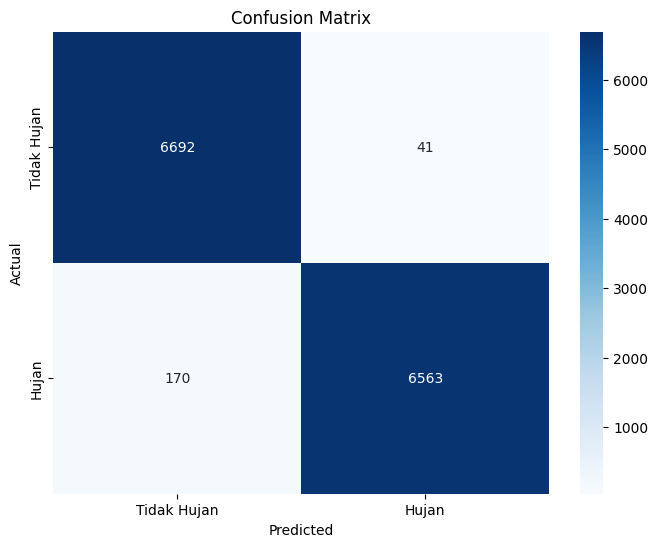

In [46]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            yticklabels=['Tidak Hujan', 'Hujan'],
            xticklabels=['Tidak Hujan', 'Hujan'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Melihat sebaran prediksi menggunakan confusion matriks, model dapat memprediksi kedua kelas secara baik

In [47]:
accuracy = classification_report(y_test, y_pred)
print(accuracy)

              precision    recall  f1-score   support

       Hujan       0.98      0.99      0.98      6733
 Tidak Hujan       0.99      0.97      0.98      6733

    accuracy                           0.98     13466
   macro avg       0.98      0.98      0.98     13466
weighted avg       0.98      0.98      0.98     13466



Hasil klasifikasi model Random Forest dengan SMOTE sangat memuaskan mencapai akuarasi 0.98

## LSTM

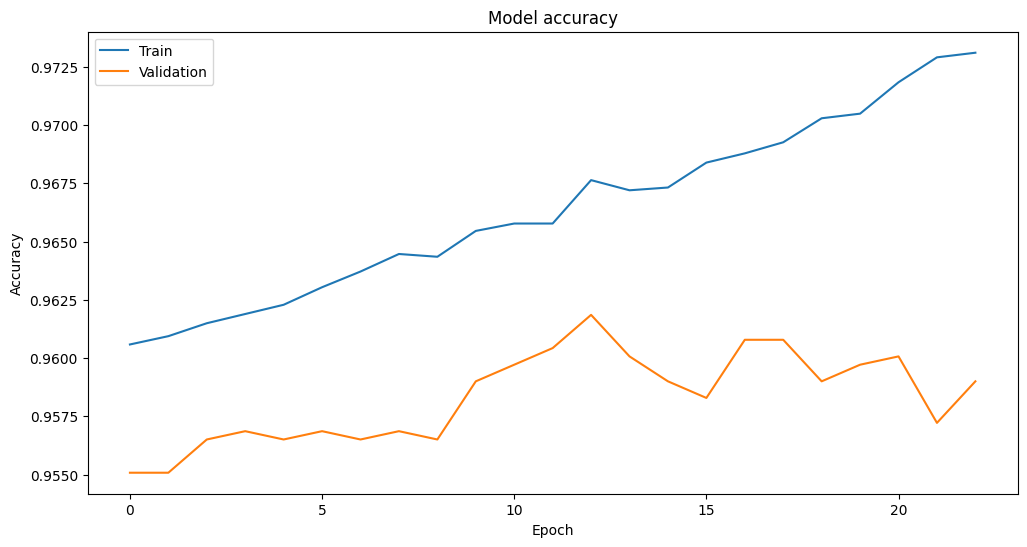

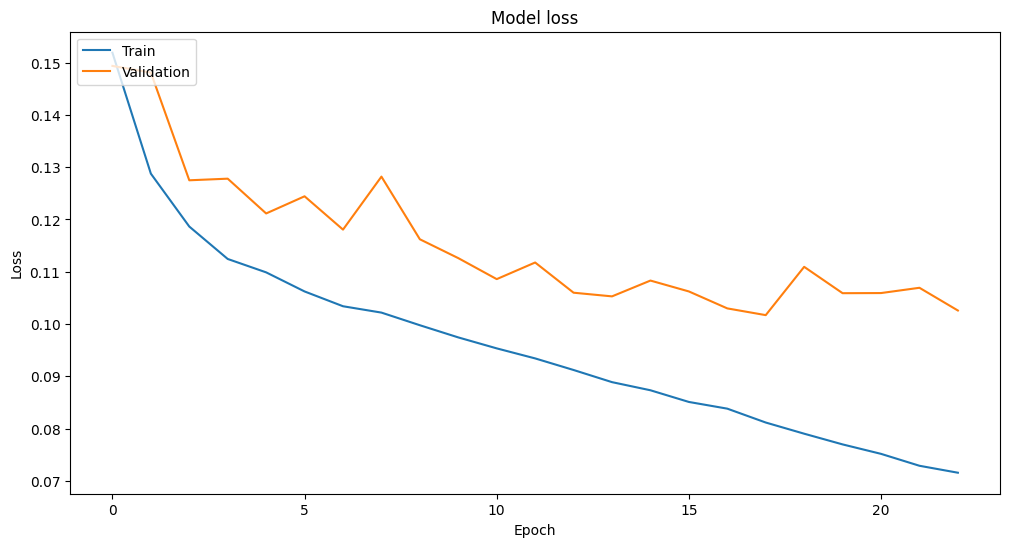

LSTM Test Accuracy: 0.9628
LSTM Test Loss: 0.1003


In [48]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

loss, accuracy = lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f'LSTM Test Accuracy: {accuracy:.4f}')
print(f'LSTM Test Loss: {loss:.4f}')


Grafik diatas adalah history hasil training pada model LSTM, model melakukan training yang bagus dimana bisa dilihat score training dan validation yang tidak beda secara signifikan

In [49]:
lstm_pred = lstm.predict(X_test_lstm)

220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Melakukan prediksi pada data test dengan model LSTM

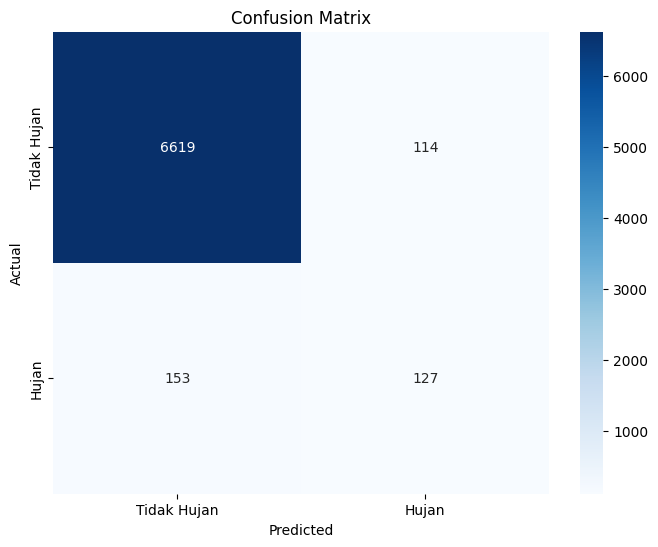

In [50]:
lstm_pred_classes = (lstm_pred > 0.3).astype(int)

# Now pass the binary predictions to confusion_matrix
cm = confusion_matrix(y_test_lstm, lstm_pred_classes) # Use lstm_pred_classes here

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            yticklabels=['Tidak Hujan', 'Hujan'], # Ensure labels match the encoded values (0 and 1)
            xticklabels=['Tidak Hujan', 'Hujan']) # Ensure labels match the encoded values (0 and 1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Melihat hasil prediksi data tes dengan confusion matriks, dapat dilihat model sulit menebak data hujan dikarenakan ketidak seimbangan data

In [51]:
accuracy = classification_report(y_test_lstm, lstm_pred_classes)
print(accuracy)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6733
           1       0.53      0.45      0.49       280

    accuracy                           0.96      7013
   macro avg       0.75      0.72      0.73      7013
weighted avg       0.96      0.96      0.96      7013



Melihat hasil klasifikasi, dimana akurasi sangat tinggi mencapai 0.96 tetapi pada kelas 1 atau Hujan score sangat rendah

In [52]:
# For Random Forest
f1_rfc = f1_score(y_test, y_pred, pos_label='Hujan') # Specify the positive class
print(f'Random Forest F1 Score: {f1_rfc:.4f}')

# For LSTM
f1_lstm = f1_score(y_test_lstm, lstm_pred_classes) # No need for pos_label if already binary (0/1)
print(f'LSTM F1 Score: {f1_lstm:.4f}')

Random Forest F1 Score: 0.9845
LSTM F1 Score: 0.4875


Melakukan pengukuran dengan F1-score karena ketidak seimbangan data, dapat dilihat bahwa Random Forest dengan SMOTE jauh signifikan lebih baik ketimbang LSTM tanpa SMOTE

# **Inference**

In [53]:
df[df['RAIN_Category'] == 'Hujan']

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,RAIN_Category
No,,,,,,,,,,,,,,,,,
268,2013,3,12,3,117.0,127.0,48.0,81.0,1262.945145,47.0,6.4,1005.8,-1.0,0.1,N,2.2,Hujan
269,2013,3,12,4,112.0,140.0,48.0,81.0,1399.000000,47.0,4.3,1006.3,1.5,0.4,E,0.9,Hujan
270,2013,3,12,5,140.0,237.0,34.0,74.0,2100.000000,47.0,4.7,1006.1,1.5,0.1,NNE,1.3,Hujan
271,2013,3,12,6,146.0,165.0,22.0,66.0,2100.000000,47.0,4.1,1006.2,2.6,0.9,W,1.0,Hujan
272,2013,3,12,7,115.0,121.0,21.0,77.0,2100.000000,47.0,3.5,1006.9,2.2,0.9,NW,1.4,Hujan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34892,2017,2,21,19,31.0,41.0,2.0,48.0,600.000000,48.0,-2.5,1022.6,-4.5,0.4,ESE,1.4,Hujan
34893,2017,2,21,20,47.0,52.0,2.0,50.0,800.000000,38.0,-2.6,1022.6,-4.3,0.5,SE,1.5,Hujan
34894,2017,2,21,21,67.0,67.0,2.0,57.0,100.000000,21.0,-2.5,1022.3,-4.1,0.8,S,1.1,Hujan


Mencari data dengan label hujan untuk dilakukan pengujian

In [54]:
#Prediksi Asli Hujan

data = {
        'month': [3],
        'day': [12],
        'PM2.5': [117.0],
        'PM10': [127.0],
        'SO2': [73.0],
        'NO2': [81.0],
        'CO': [1262.945145],
        'O3': [47.0],
        'TEMP': [6.4],
        'PRES': [1005.0],
        'DEWP': [-1],
        'WSPM': [2.2],
        'wd_E': [False],
        'wd_ENE': [False],
        'wd_ESE': [False],
        'wd_N': [True],
        'wd_NE': [False],
        'wd_NNE': [False],
        'wd_NNW': [False],
        'wd_NW': [False],
        'wd_S': [False],
        'wd_SE': [False],
        'wd_SSE': [False],
        'wd_SSW': [False],
        'wd_SW': [False],
        'wd_W': [False],
        'wd_WNW': [False],
        'wd_WSW': [False]
        }

data_df = pd.DataFrame(data)
pred = rfc.predict(data_df)
print(pred)

['Hujan']


Menggunakan salah satu data dengan label Hujan, lalu dilakukan prediksi dengan menggunakan model Random Forest yang sudah dilatih sebelumnya, hasilnya seusai yaitu Hujan

In [55]:
# Scaling (pakai scaler dari training)
data_baru_scaled = scaler.transform(data_df)

# Bentuk ke [samples, time_steps, features]
X_input = np.expand_dims(data_baru_scaled, axis=0)  # (1, 3, jumlah_fitur)

# Prediksi probabilitas hujan
prediksi = lstm.predict(X_input)

# Output probabilitas (karena sigmoid)
print("Probabilitas hujan:", prediksi[0][0])

# Konversi ke label 0 atau 1 jika perlu
label = 1 if prediksi[0][0] > 0.3 else 0
print("Apakah akan hujan?", "Ya" if label == 1 else "Tidak")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Probabilitas hujan: 0.0022569
Apakah akan hujan? Tidak


Melakukan prediksi data yang sama pada pengujian menggunakan Random Forest sebelumnya. Data di scaling terlebih dahulu dan dilakukan prediksi. Prediksi melenceng dari label yang seharusnya.